In [1]:
!git clone https://github.com/LizaDerb/probing_compositionality/

Cloning into 'probing_compositionality'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 399 (delta 50), reused 8 (delta 8), pack-reused 225
Receiving objects: 100% (399/399), 146.84 MiB | 16.52 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Updating files: 100% (72/72), done.


# English VP

## Датасет

In [2]:
import pandas as pd

In [3]:
eng = pd.read_csv('/content/probing_compositionality/data/eng/eng_corpus.csv')

Одно и то же выражение имеет и буквальное, и идиоматическое употребление. Все выражения - VP.

In [4]:
eng = eng[['mwe', 'label', 'sentence']]

In [5]:
eng.head()

,mwe,label,sentence
0,blow_smoke,L,"Anyway, Jack The Lad said, rehearsing, and ble..."
1,blow_smoke,L,"She's lying on the bed, blowing smoke at the c..."
2,blow_smoke,L,His father leaned back and blew smoke towards ...
3,blow_smoke,L,"Let us blow smoke at each other, you and I."
4,blow_smoke,L,"Let us blow smoke at each other, you and I. Sm..."


In [6]:
eng = eng[eng['label'] != 'Q']

<Axes: xlabel='mwe'>

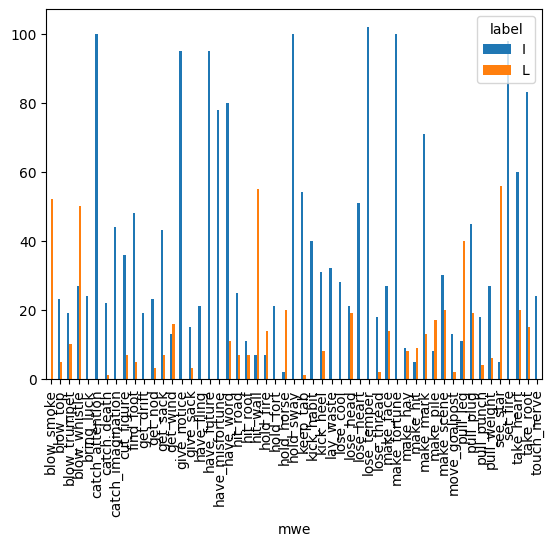

In [7]:
eng.groupby(['mwe', 'label']).size().unstack().plot(kind='bar')

In [8]:
num_idiom_eng = eng['mwe'].value_counts()
num_idiom_eng

mwe
lose_temper          102
hold_sway            100
make_fortune         100
catch_attention      100
take_root             98
set_fire              98
give_notice           95
have_future           95
have_word             91
make_mark             84
take_heart            80
have_misfortune       78
blow_whistle          77
pull_plug             64
hit_wall              62
see_star              61
keep_tab              55
find_foot             53
blow_smoke            52
pull_leg              51
lose_heart            51
make_scene            50
get_sack              50
catch_imagination     44
cut_figure            43
make_face             41
kick_habit            40
lose_head             40
kick_heel             39
pull_weight           33
lay_waste             32
hit_road              32
get_wind              29
blow_trumpet          29
blow_top              28
lose_cool             28
get_nod               26
make_pile             25
bring_luck            24
touch_nerve          

In [9]:
inx = eng[eng['label'] == 'I'].index.tolist()[::2]
eng = eng.drop(index=inx)

idiom_train_eng = num_idiom_eng[:25].index.tolist()
idiom_test_eng = num_idiom_eng[25:].index.tolist()

eng_train = eng[eng['mwe'].isin(idiom_train_eng)]
eng_test = eng[eng['mwe'].isin(idiom_test_eng)]

print('train: ', len(eng_train))
print('test: ', len(eng_test))

train:  1102
test:  448


In [10]:
stat_train_eng = eng_train['label'].value_counts().rename('num').to_frame()
stat_train_eng['percentage'] = (stat_train_eng.num * 100 / stat_train_eng.num.sum()).round(1).astype(str) + '%'
stat_train_eng

,num,percentage
label,,
I,731,66.3%
L,371,33.7%


In [11]:
stat_test_eng = eng_test['label'].value_counts().rename('num').to_frame()
stat_test_eng['percentage'] = (stat_test_eng.num * 100 / stat_test_eng.num.sum()).round(1).astype(str) + '%'
stat_test_eng

,num,percentage
label,,
I,273,60.9%
L,175,39.1%


## BERT

In [ ]:
!pip install datasets

In [13]:
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

In [14]:
import seaborn as sns
from tqdm.notebook import tqdm
import numpy as np
import warnings
import random
import pickle

import torch
from torch.utils.data import DataLoader

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from sklearn import preprocessing
from transformers import AutoTokenizer, AutoModel

In [15]:
train = Dataset.from_pandas(eng_train)
test = Dataset.from_pandas(eng_test)

In [16]:
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [17]:
train_labels = le.transform(train['label'])
test_labels = le.transform(test['label'])

In [18]:
train

Dataset({
    features: ['mwe', 'label', 'sentence', '__index_level_0__'],
    num_rows: 1102
})

In [19]:
test

Dataset({
    features: ['mwe', 'label', 'sentence', '__index_level_0__'],
    num_rows: 448
})

In [20]:
rubert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-cased')
rubert = AutoModel.from_pretrained('google-bert/bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [21]:
torch.cuda.is_available()

True

In [22]:
device_cuda = torch.device("cuda")
device_cpu = torch.device("cpu")

In [23]:
def vectorize_dataset(data, tokenizer, model):
    model = model.to(device_cuda)
    res_cls = []
    res_mean = []
    for batch in tqdm(data):
        toks = tokenizer(batch['sentence'], padding='max_length', truncation=True, return_tensors='pt', max_length=300)
        with torch.no_grad():
            model_output = model(**{k: v.to(model.device) for k, v in toks.items()})
        res_cls.append(model_output.last_hidden_state[:,0,:]) #достаём вектора для CLS токенов
        res_mean.append(torch.mean(model_output.last_hidden_state, dim=1)) #среднее
    res_cls = torch.vstack(res_cls)
    res_mean = torch.vstack(res_mean)
    return res_cls.detach().cpu().numpy(), res_mean.detach().cpu().numpy()

In [24]:
dl_train = DataLoader(train, batch_size=256, shuffle=False,
                drop_last=False)
dl_test = DataLoader(test, batch_size=256, shuffle=False,
                drop_last=False)
vecs_train_cls, vecs_train_mean = vectorize_dataset(dl_train, rubert_tokenizer, rubert)
vecs_test_cls, vecs_test_mean = vectorize_dataset(dl_test, rubert_tokenizer, rubert)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [25]:
vectors = {'vecs_train_cls' : vecs_train_cls, 'vecs_train_mean' : vecs_train_mean,
           'vecs_test_cls' : vecs_test_cls, 'vecs_test_mean' : vecs_test_mean}

for name in vectors.keys():
    with open(f'{name}.pkl', 'wb') as file:
         pickle.dump(vectors[name], file)

In [26]:
vector_names = ['vecs_train_cls', 'vecs_train_mean', 'vecs_test_cls', 'vecs_test_mean']
vecs = []

for name in vector_names:
    with open(f'{name}.pkl', "rb") as fIn:
        vecs.append(pickle.load(fIn))

train_cls = vecs[0]
train_mean = vecs[1]
test_cls = vecs[2]
test_mean = vecs[3]

In [27]:
train_cls.shape

(1102, 768)

In [28]:
test_mean.shape

(448, 768)

In [29]:
def calculate_metrics(true_labels, predictions):
    matrix = confusion_matrix(true_labels, predictions)
    acc = accuracy_score(true_labels, predictions)
    prec = precision_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, predictions)
    return matrix, acc, prec, rec, f1, roc_auc

In [30]:
def baseline_rand_vec(vecs):
    size = vecs.shape[1]
    num_vecs = vecs.shape[0]
    rand_vecs = []
    for _ in range(num_vecs):
        rand_vecs.append(np.random.uniform(-5.0826163,1.5603778,size))
    return rand_vecs

In [31]:
def baseline_rand_pred(vecs, labels):
    num_vecs = vecs.shape[0]
    rand_vecs = []
    rand_pred = np.array(range(num_vecs), dtype=int)
    for i in range(0, num_vecs):
        rand_pred[i] = random.choice(labels)
    return rand_pred

In [32]:
def rand_pred_func(vecs, labels, true_labels, n=50):
    results_rand_pred = []
    for _ in range(n):
        pred_labels = baseline_rand_pred(vecs, labels)
        results_rand_pred.append(calculate_metrics(true_labels, pred_labels))
    res_rand_pred = pd.DataFrame(results_rand_pred, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    res_rand_pred.to_csv('res_rand_pred.csv')

In [33]:
def get_results(train_data, train_labels, test_data, test_labels):
    results_train = []
    results_test = []
    for n in tqdm(range(50)):
        clf = MLPClassifier(random_state=n, max_iter=300, verbose=1)
        clf.fit(train_data, train_labels)
        train_pred = clf.predict(train_data)
        test_pred = clf.predict(test_data)
        results_train.append(calculate_metrics(train_labels, train_pred))
        results_test.append(calculate_metrics(test_labels, test_pred))
    return results_train, results_test, test_pred

In [34]:
labels = [0, 1]

In [35]:
rand_pred_func(test_cls, labels, test_labels)

In [ ]:
rand_vecs = baseline_rand_vec(train_cls)
results_train_rand, results_test_rand, test_pred_rand = get_results(rand_vecs, train_labels, test_cls, test_labels)
res_test_rand = pd.DataFrame(results_test_rand, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_train_rand = pd.DataFrame(results_train_rand, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_test_rand.to_csv('res_test_rand_vec.csv')
res_train_rand.to_csv('res_train_rand_vec.csv')

In [ ]:
results_train_mean, results_test_mean, test_pred_mean = get_results(train_mean, train_labels, test_mean, test_labels)
res_test_mean = pd.DataFrame(results_test_mean, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_train_mean = pd.DataFrame(results_train_mean, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_test_mean.to_csv('res_test_mean.csv')
res_train_mean.to_csv('res_train_mean.csv')

In [42]:
print(classification_report(test_labels, test_pred_mean, target_names=le.classes_))

              precision    recall  f1-score   support

           I       0.73      0.77      0.75       273
           L       0.61      0.56      0.58       175

    accuracy                           0.69       448
   macro avg       0.67      0.66      0.67       448
weighted avg       0.68      0.69      0.68       448



In [ ]:
results_train_cls, results_test_cls, test_pred_cls = get_results(train_cls, train_labels, test_cls, test_labels)
res_test_cls = pd.DataFrame(results_test_cls, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_train_cls = pd.DataFrame(results_train_cls, columns=['matrix', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
res_test_cls.to_csv('res_test_cls.csv')
res_train_cls.to_csv('res_train_cls.csv')

In [43]:
print(classification_report(test_labels, test_pred_cls, target_names=le.classes_))

              precision    recall  f1-score   support

           I       0.72      0.78      0.75       273
           L       0.61      0.53      0.57       175

    accuracy                           0.69       448
   macro avg       0.67      0.66      0.66       448
weighted avg       0.68      0.69      0.68       448



In [44]:
!zip -r /content/file.zip /content/english_vp

  adding: content/english_vp/ (stored 0%)
  adding: content/english_vp/vecs_train_mean.pkl (deflated 8%)
  adding: content/english_vp/res_train_cls.csv (deflated 92%)
  adding: content/english_vp/vecs_train_cls.pkl (deflated 8%)
  adding: content/english_vp/res_test_rand_vec.csv (deflated 75%)
  adding: content/english_vp/res_train_mean.csv (deflated 92%)
  adding: content/english_vp/vecs_test_mean.pkl (deflated 8%)
  adding: content/english_vp/res_test_mean.csv (deflated 75%)
  adding: content/english_vp/res_rand_pred.csv (deflated 68%)
  adding: content/english_vp/res_train_rand_vec.csv (deflated 92%)
  adding: content/english_vp/vecs_test_cls.pkl (deflated 7%)
  adding: content/english_vp/res_test_cls.csv (deflated 75%)
